In [1]:
if (!require(pacman)) install.packages('pacman')
pacman::p_load(tidyverse,
               arrow,
               broom,
               recipes,
               parsnip,
               tidymodels,
               FactoMineR,
               factoextra,
               install = TRUE)

Loading required package: pacman



load data set

In [2]:
bikedata <- read_parquet(".././data/bikeshare-data.parquet")

### Feature Engineering
Create some intermediate features from the date field

In [3]:
bikedata <- bikedata %>%
    mutate(year = as.factor(lubridate::year(trip_date)),
           month = lubridate::month(trip_date, label = TRUE),
           wday = lubridate::wday(trip_date, label = TRUE)) %>%
    select(-total_seconds)

In [4]:
head(bikedata)

trip_date,trip_count,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,year,month,wday
<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<ord>,<ord>
2018-01-01,1099,11.63,0.0,0.0,0.0,19,26,13,2018,Jan,Mon
2018-01-02,3796,7.83,0.0,0.0,0.0,18,26,13,2018,Jan,Tue
2018-01-03,4742,3.80,0.0,0.0,0.0,23,35,13,2018,Jan,Wed
2018-01-04,2359,19.91,0.1,0.8,1.2,26,27,16,2018,Jan,Thu
2018-01-05,2735,15.66,0.0,0.0,1.2,17,21,13,2018,Jan,Fri
2018-01-06,1510,13.42,0.0,0.0,0.0,15,21,11,2018,Jan,Sat


 split into training and test data sets based on time period

In [5]:
train_row_length <- floor(NROW(bikedata) * 0.80) # use a 80/20 split

train_set <- bikedata[1:train_row_length, ]
test_set  <- bikedata[train_row_length:NROW(bikedata),]

build some simple models to look at predictive ability

In [6]:
# create model recipe to preduct trip count
rec_count <- recipe(trip_count ~ ., data = bikedata) %>%
    update_role(trip_date, new_role = 'ID') %>%
    step_dummy(all_nominal(),
               one_hot = FALSE) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors()) %>%
    step_zv(all_predictors())

In [7]:
# apply this recipe to the train data
rec_count <- prep(rec_count, training = train_set)
rec_count

Data Recipe

Inputs:

      role #variables
        ID          1
   outcome          1
 predictor         10

Training data contained 779 data points and 1 incomplete row. 

Operations:

Dummy variables from year, month, wday [trained]
Centering for AWND, PRCP, SNOW, SNWD, TAVG, TMAX, ... [trained]
Scaling for AWND, PRCP, SNOW, SNWD, TAVG, TMAX, ... [trained]
Zero variance filter removed no terms [trained]

In [8]:
count_train <- juice(rec_count)
count_test  <- bake(rec_count, test_set)

In [9]:
head(count_train, 3)

trip_date,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,trip_count,year_X2019,...,month_08,month_09,month_10,month_11,wday_1,wday_2,wday_3,wday_4,wday_5,wday_6
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-01-01,0.9177032,-0.3734403,-0.08366953,-0.09976224,-2.275642,-2.243571,-2.20199,1099,-0.9383553,...,0.1549744,-0.06994748,0.01133315,0.0001198467,-0.99791599,0.001111894,1.07643249,-1.4895470,1.1532813845,-0.5229105
2018-01-02,-0.2270282,-0.3734403,-0.08366953,-0.09976224,-2.332910,-2.243571,-2.20199,3796,-0.9383553,...,0.1549744,-0.06994748,0.01133315,0.0001198467,-0.49799537,-0.865053223,1.07643249,0.2146676,-1.4407692369,1.3037589
2018-01-03,-1.4410459,-0.3734403,-0.08366953,-0.09976224,-2.046569,-1.755224,-2.20199,4742,-0.9383553,...,0.1549744,-0.06994748,0.01133315,0.0001198467,0.00192524,-1.153774928,-0.00277074,1.2798018,0.0003699972,-1.7406901


### Dimension Reduction
PCA

In [10]:
count_pca <- count_train %>%
    select(-trip_count) %>%
    select_if(is.numeric) %>%
    drop_na() %>%
    PCA(scale.unit = TRUE, graph = FALSE, ncp = 5)

In [11]:
get_eigenvalue(count_pca) %>% head(10)

,eigenvalue,variance.percent,cumulative.variance.percent
Dim.1,4.017137,15.450526,15.45053
Dim.2,1.531138,5.888994,21.33952
Dim.3,1.400146,5.385178,26.72470
Dim.4,1.229002,4.726930,31.45163
Dim.5,1.181594,4.544591,35.99622
Dim.6,1.085168,4.173724,40.16994
Dim.7,1.042881,4.011082,44.18103
Dim.8,1.036042,3.984777,48.16580
Dim.9,1.016874,3.911053,52.07686
Dim.10,1.005852,3.868661,55.94552


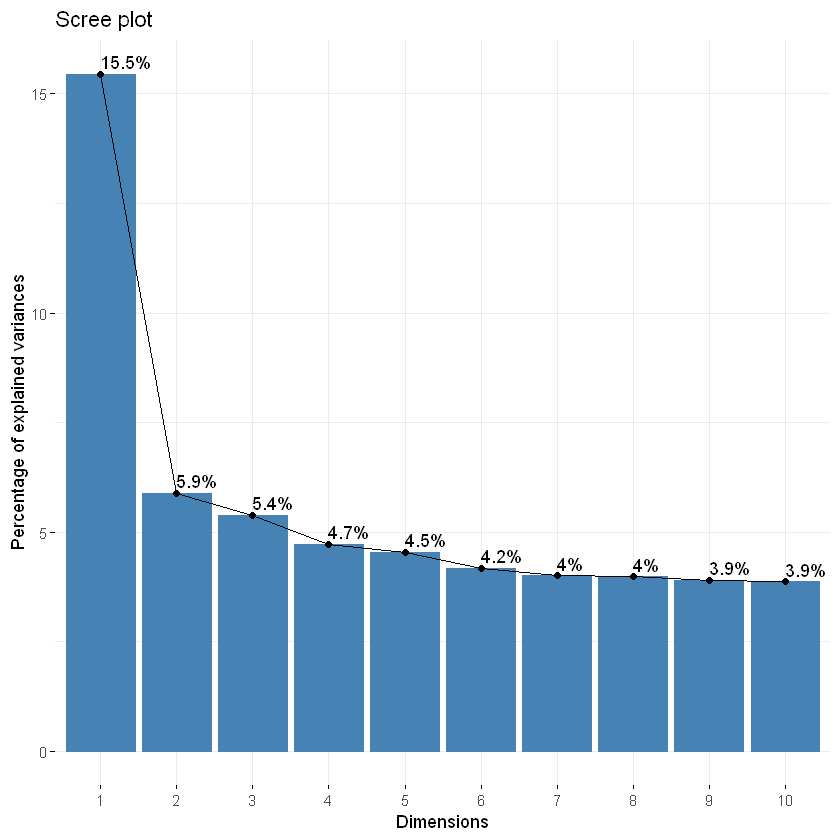

In [12]:
factoextra::fviz_eig(count_pca, addlabels = TRUE)

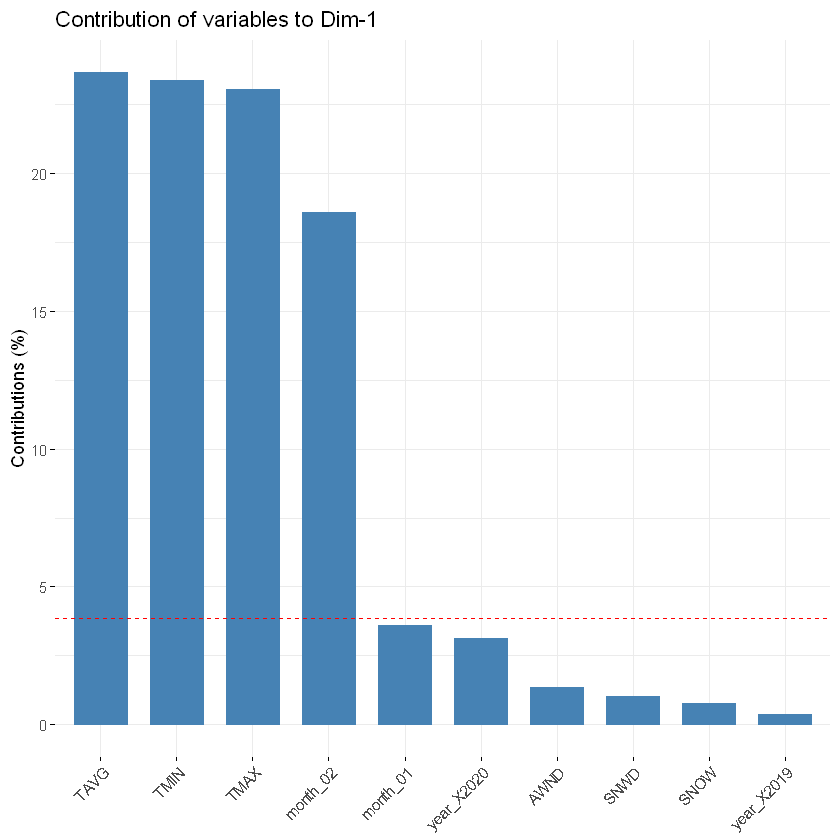

In [13]:
fviz_contrib(count_pca, choice = "var", axes = 1, top = 10)

Based on this, it doesn't look like PCA helps very much. We will proceed with all variables.

Save the data set

In [14]:
bike_data_grid <- bake(rec_count, bikedata)

In [17]:
write_parquet(bike_data_grid, ".././data/bikeshare-data-grid.parquet")